In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# impostazione per vedere tutte le colonno di un DataFrame
pd.set_option('display.max_columns',None)

NameError: ignored

In [ ]:
df = pd.read_csv('housing.csv')

In [ ]:
df.shape

(1460, 81)

# TRAIN/TEST SPLIT

Prima di tutto dividiamo il set in dati di TRAINING e dati di TEST. Questo è fondamentale per poter testare le capacità predittive di un modello su dati che non ha mai incontrato. sklearn mette a disposizione una comodo funzione per fare questo: train_test_split()

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.25, shuffle=True, random_state=22)

Riduciamo il nostro train_df alla singola variabile 'GrLivArea', una delle più correlate con SalePrice. Solitamente si usa indicare con X l'insieme delle 'features' e con y il target da prevedere.

In [ ]:
train_df.shape

(1095, 81)

In [ ]:
test_df.shape

(365, 81)

In [ ]:
X_train = train_df['GrLivArea'].copy()
y_train = train_df['SalePrice'].copy()

X_test = test_df['GrLivArea'].copy()
y_test = test_df['SalePrice'].copy()

In [ ]:
# check se ci sono valori nulli
print(X_train.isna().any())
print(y_train.isna().any()) 
print(X_test.isna().any())
print(y_test.isna().any()) 

False
False
False
False


# MODELLO LINEARE 'HOME-MADE'

#### 1. FITTING

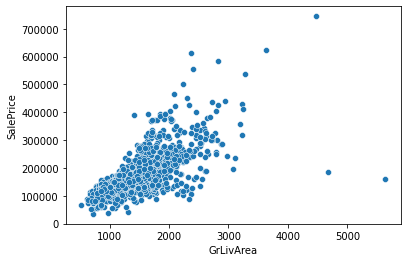

In [ ]:
sns.scatterplot(x=X_train, y=y_train);

Essendo la correlazione così ben visibile possiamo aspettarci che una semplice 'retta' sia già un buon modello che ci permetta di prevedere SalePrice conoscendo GrLivArea. Ma come scegliamo la retta giusta?

Una retta è identificata da due parametri: l'inclinazione e l'intercetta. Andando a occhio si può dire che l'intercetta sia vicina o poco superiore a 0, il che ha senso pensando che una casa di 0 metri quadrati valga... 0. Quindi per ora concentriamoci sull'inclinazione, per la quale possiamo andare un pò a tentativi. Proviamo a scrivere la retta direttamente 'a mano' (niente paura, non lo faremo più andando avanti :) )

In [ ]:
# inclinazione
alpha = 50

# intercetta
beta = 0

preds = (alpha * X_train) + beta

In [ ]:
preds

571      43200
1356     44600
198     111450
230      59700
986      81750
         ...  
356      58350
960      42900
812      52200
132      66350
885      85450
Name: GrLivArea, Length: 1095, dtype: int64

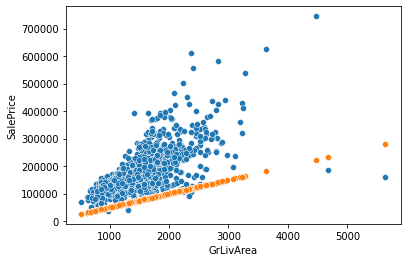

In [ ]:
sns.scatterplot(x=X_train, y=y_train)
sns.scatterplot(x=X_train, y=preds)
plt.show()

Ok, l'inclinazione è evidentemente troppo bassa. Proviamone un pò

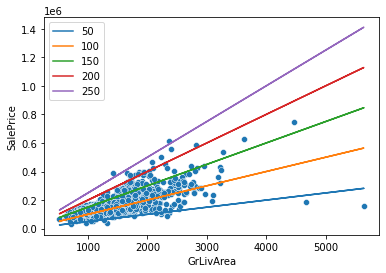

In [ ]:
sns.scatterplot(x=X_train, y=y_train)

for alpha in [50,100,150,200,250]:
    preds = (alpha * X_train) + 0
    plt.plot(X_train, preds, label=alpha)
plt.legend()
plt.show()

Sembra che l'inclinazione giusta sia da qualche parte tra 100 e 150 ... ma per sceglierne una si deve poter valutare quantitativamente la bontà di questo primo modello. Bisogna scegliere una metrica di valutazione. 

Per esempio si Può usare il Mean Absolute Error (MAE), che è il valore assoluto della distanza di ogni dato reale dalla retta scelta. Ci viene in aiuto sklearn, che mette a disposizione una serie molto ampia di metriche di valutazione, tra cui anche il MAE.

In [ ]:
from sklearn.metrics import mean_absolute_error

# calcoliamolo per ogni retta
for alpha in [50,100,150,200,250]:
    preds = alpha * X_train
    mae = mean_absolute_error(y_train, preds)
    print('MAE (alpha={}): {} '.format(alpha, mae))


MAE (alpha=50): 104980.17808219178 
MAE (alpha=100): 45324.71324200913 
MAE (alpha=150): 57521.12602739726 
MAE (alpha=200): 122741.0401826484 
MAE (alpha=250): 196996.45570776256 


In [ ]:

# calcoliamolo per ogni retta, sichiama fitting
for alpha in range(100,200,5):
    preds = alpha * X_train
    mae = mean_absolute_error(y_train, preds)
    print('MAE (alpha={}): {} '.format(alpha, mae))

MAE (alpha=100): 45324.71324200913 
MAE (alpha=105): 42288.64657534246 
MAE (alpha=110): 40128.5598173516 
MAE (alpha=115): 39030.25388127854 
MAE (alpha=120): 38931.739726027394 
MAE (alpha=125): 39815.24748858447 
MAE (alpha=130): 41714.850228310504 
MAE (alpha=135): 44566.98630136986 
MAE (alpha=140): 48283.81461187215 
MAE (alpha=145): 52615.63287671233 
MAE (alpha=150): 57521.12602739726 
MAE (alpha=155): 62928.06210045662 
MAE (alpha=160): 68685.92420091324 
MAE (alpha=165): 74764.9205479452 
MAE (alpha=170): 81111.84566210046 
MAE (alpha=175): 87696.9095890411 
MAE (alpha=180): 94438.63287671233 
MAE (alpha=185): 101358.58630136987 
MAE (alpha=190): 108409.85114155251 
MAE (alpha=195): 115533.47762557077 


Sembra in effetti che il MAE più basso ce l'abbia la retta con inclinazione 100. In questo caso il modello sbaglia mediamente la valutazione del prezzo di 44 mila dollari circa. Come possiamo migliorare il fit del modello ai dati? Ora che abbiamo scelto una metrica di valutazione possiamo provare a ottimizzare il parametro alpha diminuendo lo step tra un alpha e l'altro. Inoltre, già che ci siamo, possiamo provare anche a trovare un buon beta

In [ ]:
error_df = pd.DataFrame(columns=['alpha','beta','MAE'])

# calcoliamolo per ogni retta
n=0
for alpha in np.arange(100, 150, 5):
    for beta in np.arange(0,10000, 500):
        preds = (alpha * X_train) + beta
        mae = mean_absolute_error(y_train, preds)
        
        error_df = error_df.append({'alpha':alpha, 'beta':beta, 'MAE':mae}, ignore_index=True)
        
        print('MAE (alpha={}, beta={}): {} '.format(alpha, beta, mae))
                
        n+=1
        

MAE (alpha=100, beta=0): 45324.71324200913 
MAE (alpha=100, beta=500): 45073.84566210046 
MAE (alpha=100, beta=1000): 44826.08310502283 
MAE (alpha=100, beta=1500): 44583.10593607306 
MAE (alpha=100, beta=2000): 44345.20639269406 
MAE (alpha=100, beta=2500): 44110.594520547944 
MAE (alpha=100, beta=3000): 43878.72237442922 
MAE (alpha=100, beta=3500): 43651.59908675799 
MAE (alpha=100, beta=4000): 43429.04200913242 
MAE (alpha=100, beta=4500): 43209.95525114155 
MAE (alpha=100, beta=5000): 42996.16529680365 
MAE (alpha=100, beta=5500): 42788.037442922374 
MAE (alpha=100, beta=6000): 42586.48493150685 
MAE (alpha=100, beta=6500): 42391.59908675799 
MAE (alpha=100, beta=7000): 42199.36164383562 
MAE (alpha=100, beta=7500): 42009.80182648402 
MAE (alpha=100, beta=8000): 41823.04383561644 
MAE (alpha=100, beta=8500): 41640.77899543379 
MAE (alpha=100, beta=9000): 41463.33607305936 
MAE (alpha=100, beta=9500): 41289.911415525115 
MAE (alpha=105, beta=0): 42288.64657534246 
MAE (alpha=105, b

In [ ]:
error_df

,alpha,beta,MAE
0,100.0,0.0,45324.713242
1,100.0,500.0,45073.845662
2,100.0,1000.0,44826.083105
3,100.0,1500.0,44583.105936
4,100.0,2000.0,44345.206393
...,...,...,...
195,145.0,7500.0,57535.413699
196,145.0,8000.0,57883.130594
197,145.0,8500.0,58234.829224
198,145.0,9000.0,58589.934247


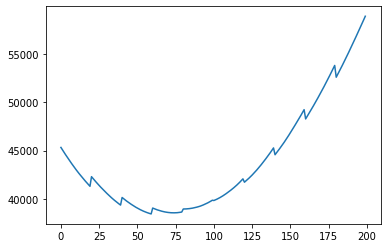

In [ ]:
plt.plot(error_df['MAE']);
plt.show()

Per trovare il modello migliore a questo punto basta trovare il MAE minimo, et voilà...! Avremo trovato i migliori parametri della retta. 

In gergo tecnico, quella che vedete plottata qui sopra si chiama 'LOSS FUNCTION', ed è la funzione da minimizzare (o in altri casi massimizzare) per trovare il modello che fitta meglio i dati. Non a caso, questa fase si chiama proprio FITTING.

Non è affatto detto che usare il MAE come loss function sia la scelta migliore! In effetti c'è un vera e propria miriade di possibili loss function. Per nostra fortuna sklearn (e tante altre librerie) già incorporano la maggior parte di queste, e di fatto non dovremo preoccuparcene troppo. Ma in questo caso è semplice trovare un minimo, quindi facciamo a mano.

In [ ]:
# troviamo il MAE minimo
print('min MAE: ', error_df['MAE'].min())

min MAE:  38421.83287671233


In [ ]:
# e i corrispondenti parametri della retta
min_index = error_df['MAE'].idxmin()
print('Alpha: ', error_df.loc[min_index]['alpha'])
print('Beta: ', error_df.loc[min_index]['beta'])

Alpha:  110.0
Beta:  9500.0


Ok, sembra che la retta migliore (cioè quella che ha il MAE più basso sui dati di training) sia quella con alpha=115 e beta=9500, con un MAE di circa 37k. Abbiamo dunque il nostro primo modello! Che è capace di dare una previsione del prezzo di una casa (per quanto ancora parecchio imprecisa) a partire dalla sola metratura del piano terra.

#### 2. EVALUATION

Ora ci rimane solo da testare il modello con dati ancora mai incontrati. A questo serve il test set che ci siamo tenuti da parte all'inizio.

In [ ]:
alpha = 115
beta = 9500

test_preds = (alpha * X_test) + beta

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)

print('TEST SET')
print('MAE: ', mae)
print('R2: ', r2)

TEST SET
MAE:  36728.53424657534
R2:  0.5945564465424646


Ok, il MAE è abbastanza vicino a quello trovato sui dati di training, ma chiaramente diverse visto che viene calcolato su altri dati.

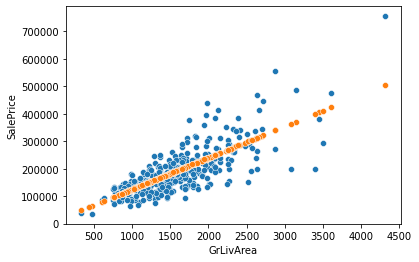

In [ ]:
sns.scatterplot(x=X_test, y=y_test)
sns.scatterplot(x=X_test, y=test_preds)
plt.show()

# SCIKIT-LEARN: LinearRegression()

Come avrete notato può non essere così banale trovare il risultato migliore, soprattutto quando i parametri del modello cominciano ad aumentare. Per fortuna sklearn ha già integrati una serie di algoritmi di fitting dei modelli. Se volessimo riscrivere questo processo usando sklearn basterbbe: 
- scegliere e inizializzare un modello, in questo caso sklearn.linear_model.LinearRegression
- chiamare il metodo .fit() per fittare il modello ai dati
- chiamare il metodo .predict() per calcolare le previsioni del modello sul test set
- valutare la performance del modello sul test set con una metrica scelta, per esempio il MAE.

### SINGOLA FEATURE

#### 1. FITTING DEL MODELLO: .fit()

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

Come abbiamo visto il fitting è un processo che prevede la minimizzazione di una metrica di 'loss function'. Prima abbiamo usato il MAE per semplicità. La LinearRegression di sklearn usa il metodo 'Ordinary Least Squares' (OLS), che è un processo iterativo in cui per ogni insieme di parametri che definiscono il modello (in questo caso la retta) si calcola l'errore quadratico (y-pred)^2, e cerca di minimizzarlo.
Per qualche info in più: https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares

In [ ]:
#Per dataset con un singola variabile sklearn richiede un reshaping, ma in tutti gli altri casi basterà passare direttamente il DataFrame 
X_train_reshaped = X_train.to_numpy().reshape(-1,1)
model = model.fit(X=X_train_reshaped, y=y_train)

NameError: ignored

In [ ]:
model.coef_

In [ ]:
print('Inclinazione: ',model.coef_)
print('Intercetta: ',model.intercept_)

#### 2. EVALUATION SUL TEST SET: .predict()

In [ ]:
X_test_reshaped = X_test.to_numpy().reshape(-1, 1)

train_preds = model.predict(X_train_reshaped)
test_preds = model.predict(X_test_reshaped)

In [ ]:
train_mae = mean_absolute_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)

print('TRAIN SET')
print('MAE: ', train_mae)
print('R2: ', train_r2)

test_mae = mean_absolute_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

print('\nTEST SET')
print('MAE: ', test_mae)
print('R2: ', test_r2)

In [ ]:
###### previsioni VS targets
sns.scatterplot(x=y_train, y=train_preds)
###### retta di perfect fit
plt.plot(range(0,y_train.max()), range(0,y_train.max()), label='perfect fit')
plt.title('TRAIN SET')
plt.legend()
plt.show()

###### previsioni VS targets
sns.scatterplot(x=y_test, y=test_preds)
###### retta di perfect fit
plt.plot(range(0,y_test.max()), range(0,y_test.max()), label='perfect fit')
plt.title('TEST SET')
plt.legend()
plt.show()

Lo scatter plot delle previsioni contro i target è molto informativo. Se le previsioni fossero perfette starebbero tutte sulla retta di perfect fit, che è proprio la retta in cui xè sempre uguale a y.
In questo caso è evidente che il modello sottostima in modo consistente le case con prezzi più alti, e sovrastima quelle con prezzo più basso.

!!BONUS!! visto che la useremo molto, per fare prima possiamo definire una funzione che ci restituisce come output le metriche di valutazione e fa il plot del fit

In [ ]:
def evaluate(targets, preds, title, plots=True, verbose=True):
    
    mae = mean_absolute_error(targets, preds)
    r2 = r2_score(targets, preds)
    
    if verbose:
        print(title)
        print('MAE: ', mae)
        print('R2: ', r2)
    
    if plots:
        ###### previsioni VS targets
        sns.scatterplot(x=targets, y=preds)
        ###### retta di perfect fit
        plt.plot(range(0,targets.max()), range(0,targets.max()), label='perfect fit')
        plt.title(title)
        plt.legend()
        plt.show()
    
    return {'mae':mae, 'r2':r2}

In [ ]:
train_metrics = evaluate(targets=y_train, preds=train_preds, title='TRAIN SET')
test_metrics = evaluate(targets=y_test, preds=test_preds, title='TEST SET')

### 3 FEATURES

Recuperiamo altre features numeriche per migliorare il nostro forecast. Prediamone per esempio 3 in tutto: 'OverallQual', 'GrLivArea', 'GarageCars', che erano le più correlate quando abbiamo fatto la dataset exploration

In [ ]:
features_list = ['GrLivArea', 'OverallQual', 'GarageCars']

X_train = train_df[features_list].copy()
y_train = train_df['SalePrice'].copy()

X_test = test_df[features_list].copy()
y_test = test_df['SalePrice'].copy()

In [ ]:
### FITTING

from sklearn.linear_model import LinearRegression
model = LinearRegression()

model = model.fit(X=X_train, y=y_train)

In [ ]:
print('Inclinazione: ')
for coef in model.coef_:
    print(coef)
print('\nIntercetta: ', model.intercept_)

Inclinazione: 
46.016178124027626
27483.8854680132
22732.661411843383

Intercetta:  -96670.0550473473


In questo caso il modello lineare avrà un coefficiente di inclinazione per ogni feature. Si parla in questo caso regressione lineare multi-variata (in contrasto alla regressione uni-variata).

TRAIN SET
MAE:  27696.774541071834
R2:  0.7249477063817809


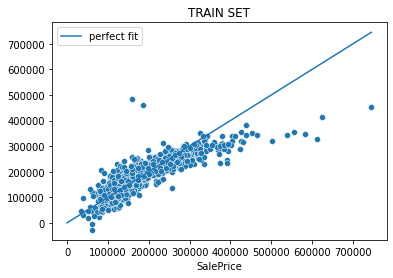

TEST SET
MAE:  27059.026850298756
R2:  0.7743137292881643


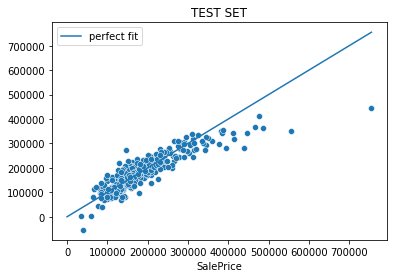

In [ ]:
### EVALUATION

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_metrics = evaluate(targets=y_train, preds=train_preds, title='TRAIN SET')
test_metrics = evaluate(targets=y_test, preds=test_preds, title='TEST SET')

Si nota un netto miglioramento, anche solo aumentando il numero di feature che diamo in pasto al modello.

Il fit è migliorato, anche se ancora sulle case con prezzi più alti ha una sottostima evidente.

### 6 FEATURES

Recuperiamo altre features numeriche per migliorare il nostro forecast. Prediamone per esempio 3 in tutto: 'OverallQual', 'GrLivArea', 'GarageCars', che erano le più correlate quando abbiamo fatto la dataset exploration

In [ ]:
features_list = ['OverallQual', 'GrLivArea', 'GarageCars','TotalBsmtSF', 'FullBath','TotRmsAbvGrd']

X_train = train_df[features_list].copy()
y_train = train_df['SalePrice'].copy()

X_test = test_df[features_list].copy()
y_test = test_df['SalePrice'].copy()

In [ ]:
### FITTING

from sklearn.linear_model import LinearRegression
model = LinearRegression()

model = model.fit(X=X_train, y=y_train) 

In questo caso il modello lineare avrà un coefficiente di inclinazione per ogni feature. Si parla in questo caso regressione lineare multi-variata (in contrasto alla regressione uni-variata).

TRAIN SET
MAE:  25577.102798530974
R2:  0.7441299573486234


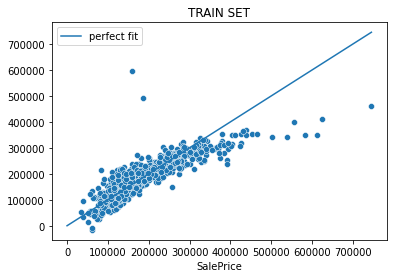

TEST SET
MAE:  24763.007758303855
R2:  0.8009568679333834


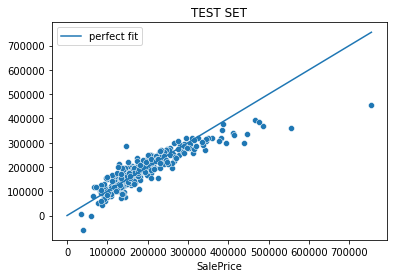

In [ ]:
### EVALUATION

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# usiamo la funzione che abbiamo definito prima
train_metrics = evaluate(targets=y_train, preds=train_preds, title='TRAIN SET')
test_metrics = evaluate(targets=y_test, preds=test_preds, title='TEST SET')

### CATEGORICAL FEATURES

Se voglio aggiungere variabile categoriche alla previsione, non posso lasciarle così come sono. Scikit-learn si aspetta solo variabile numeriche in input, non riesce a processare delle stringhe. La variabie MSZoning, per esempio, ha 5 categorie possibili:

In [ ]:
set(train_df['MSZoning'])

{'C (all)', 'FV', 'RH', 'RL', 'RM'}

Una possibilità sarebbe quella di assegnare a ogni categoria un numero. Ma questa tecnica può dare dei problemi, perchè il modello potrbbe implicitamente inferire che c'è una relazione incrementale tra una categoria e l'altra. Per evitare questo problema si utilizza un altro metodo: si creano delle cosiddette variabili 'dummy'. Nel caso di MSZoning dovrò trasformare la variabile in 5 variabili distinte (una per categoria), che avranno valore 1 o 0. Se per esempio una casa appartiene alla categoria di MSZoning 'FV', allora avrò la dummy 'FV' 1, e le altre 4 dummy 0.

pandas mette a disposizione una funzione specifica per questo: .get_dummies(). Questa funzione ha dei limiti e per progetti più strutturati converrebbe usare OneHotEncoder() di scikit-learn, che può essere per esempio insierita in una pipeline di scikit-learn. Ad ogni modo per i nostri scopi get_dummies è molto più comoda

In [ ]:
categorical_features = ['MSZoning','Neighborhood']
train_dummies = pd.get_dummies(train_df[categorical_features], drop_first=True)

Aggiungiamole a quelle numeriche di prima:

In [ ]:
features_list = ['OverallQual', 'GrLivArea', 'GarageCars','TotalBsmtSF', 'FullBath','TotRmsAbvGrd']

X_train = train_df[features_list].copy()
y_train = train_df['SalePrice'].copy()

X_test = test_df[features_list].copy()
y_test = test_df['SalePrice'].copy()

In [ ]:
train_dummies = pd.get_dummies(train_df[categorical_features], drop_first=True)
X_train = pd.concat([X_train,train_dummies], axis=1, ignore_index=False)

test_dummies = pd.get_dummies(test_df[categorical_features], drop_first=True)
X_test = pd.concat([X_test,test_dummies], axis=1, ignore_index=False)

In [ ]:
X_train

In [ ]:
### FITTING

from sklearn.linear_model import LinearRegression
model = LinearRegression()

model = model.fit(X=X_train, y=y_train)

In [ ]:
### EVALUATION

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# usiamo la funzione che abbiamo definito prima
train_metrics = evaluate(targets=y_train, preds=train_preds, title='TRAIN SET')
test_metrics = evaluate(targets=y_test, preds=test_preds, title='TEST SET')

# K-NEAREST NEIGHBORS (KNN)

In [ ]:
### FITTING

from sklearn.neighbors import KNeighborsRegressor
 
model = KNeighborsRegressor(n_neighbors = 5)
model = model.fit(X_train, y_train)


In [ ]:
### EVALUATION

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_metrics = evaluate(targets=y_train, preds=train_preds, title='TRAIN SET')
test_metrics = evaluate(targets=y_test, preds=test_preds, title='TEST SET')

### K parameter: Increasing model complexity

In [ ]:
X_train = train_df['GrLivArea'].to_numpy().reshape(-1,1)
X_test = test_df['GrLivArea'].to_numpy().reshape(-1,1)

In [ ]:
train_mae_list = list()
test_mae_list = list()

k_list = range(1, 1000, 5)

for k in k_list:
    
    model = KNeighborsRegressor(n_neighbors = k)
    model = model.fit(X_train, y_train)
    
    ### EVALUATION
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_metrics = evaluate(targets=y_train, preds=train_preds, title='TRAIN SET', plots=False, verbose=False)
    test_metrics = evaluate(targets=y_test, preds=test_preds, title='TEST SET', plots=False, verbose=False)
    
    train_mae_list += [train_metrics['mae']]
    test_mae_list += [test_metrics['mae']]
        

In [ ]:
plt.plot(k_list, train_mae_list, label='TRAIN')
plt.plot(k_list, test_mae_list, label='TEST')
plt.legend()

In [ ]:



fig, subaxes = plt.subplots(1, 2, figsize=(8,4))
X_predict_input = np.linspace(-3, 3, 50).reshape(-1,1)

for thisaxis, K in zip(subaxes, [1, 3]):
    knnreg = KNeighborsRegressor(n_neighbors = K).fit(X_train, y_train)
    y_predict_output = knnreg.predict(X_predict_input)
    thisaxis.set_xlim([-2.5, 0.75])
    thisaxis.plot(X_predict_input, y_predict_output, '^', markersize = 10,
                 label='Predicted', alpha=0.8)
    thisaxis.plot(X_train, y_train, 'o', label='True Value', alpha=0.8)
    thisaxis.set_xlabel('Input feature')
    thisaxis.set_ylabel('Target value')
    thisaxis.set_title('KNN regression (K={})'.format(K))
    thisaxis.legend()
plt.tight_layout()